$ \log \mathcal{B}(r_m | \rho_m) = r_m \log \rho_m + (1 - r_m) \log(1 - \rho_m) $

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from math import pi

from tqdm import tqdm
tqdm.pandas()

In [230]:
# Import WRF model and bias corrected precipitation into a a XArray Dataset
wrf_path = '..\..\..\Google Drive (mg963)/PhD/data/wrf/precipitation.nc'
ds = xr.open_dataset(wrf_path)

# Import SRTM Digital Elevation Model into a xarray DataArray
srtmfull_path = '..\..\..\Google Drive (mg963)/PhD/gis/srtm_dem.tif'
srtm_full = xr.open_rasterio(srtmfull_path)

srtm_path = '..\..\..\Google Drive (mg963)/PhD/gis/srtm_dem_resampled.tif'
srtm = xr.open_rasterio(srtm_path)
#srtm = srtm.to_dataset(name="SRTM").rename({"x":"projection_x_coordinate", "y":"projection_y_coordinate"})

In [194]:
%%time 
df = ds.isel(time=1).to_dataframe().reset_index()

Wall time: 131 ms


In [213]:
def select_from_2D_xarray(df, da, dim1, dim2):
    a = da.sel(x=df[dim1],
               y=df[dim2],
               method="nearest").values
    return float(a)

In [214]:
df['srtm'] = df.progress_apply(select_from_2D_xarray, axis=1, args=(srtm, 'projection_x_coordinate', 'projection_y_coordinate'))

100%|███████████████████████████████████████████████████████████████████████████| 30888/30888 [00:47<00:00, 655.53it/s]


In [400]:
df = df[df['bnds']==0]

In [401]:
# Add DOY information
df['doy'] = df['time'].dt.dayofyear
df['doy_sin'] = df['doy'].transform(lambda x: np.sin(x*2*pi/365))
df['doy_cos'] = df['doy'].transform(lambda x: np.cos(x*2*pi/365))

In [413]:
t = 200

# Drop columns
df2 = df.drop(columns=['time','time_bnds','lambert_conformal_conic','bnds','model_precipitation','bias_corrected_precipitation'])


# Add model precipitation values
for i in [-2,-1,0,1,2]:
    df3 = ds.isel(time = t+i).to_dataframe().reset_index()[['model_precipitation']]#,'bias_corrected_precipitation']]
    
    df3.rename(columns={'model_precipitation': f'wrf_prcp_{i}',
                        #'bias_corrected_precipitation': f'bcp{i}'
                       }, 
               inplace=True)
                        
    df2 = df2.join(df3)
    
df2.rename(columns={'wrf_prcp_0':'wrf_prcp'},inplace=True)

In [414]:
# # Join WRF data for time=2
# df2 = df2.join(df3)

In [415]:
# df2.drop(columns=['XLAT','XLONG'], inplace=True)

In [416]:
df2.rename(columns={'projection_x_coordinate':'X',
                    'projection_y_coordinate':'Y',
                    'srtm':'Z'}, inplace=True)

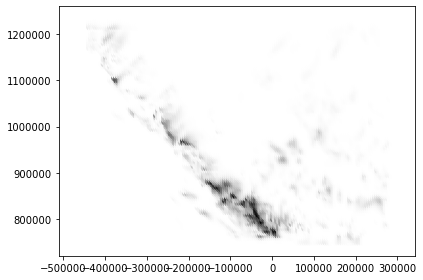

In [417]:
plt.scatter(x=df2['X'], y=df2['Y'], c=df2['wrf_prcp'], cmap="binary")
plt.tight_layout()
plt.show()

In [418]:
SAVE_PATH = '..\..\PhD/data/pickle/df_map1.pkl'
df2.to_pickle(SAVE_PATH)

In [399]:
df2.describe()

,X,Y,XLAT,XLONG,Z,doy,doy_sin,doy_cos,wrf_prcp_-2,wrf_prcp_-1,wrf_prcp,wrf_prcp_1,wrf_prcp_2
count,15444.000000,1.544400e+04,15444.000000,15444.000000,15444.000000,15444.0,1.544400e+04,1.544400e+04,15444.0,15444.000000,15444.000000,15444.000000,15444.000000
mean,-84409.944923,9.904535e+05,31.866741,79.106522,1641.497312,2.0,3.442161e-02,9.994074e-01,0.0,18.071215,4.762977,1.075500,0.056928
std,225169.268713,1.428915e+05,1.284290,2.383961,2080.935956,0.0,6.939119e-18,1.110259e-16,0.0,30.122810,10.561343,4.427660,0.665595
min,-471909.944923,7.454535e+05,29.597443,74.891113,0.000000,2.0,3.442161e-02,9.994074e-01,0.0,0.000000,0.000000,0.000000,0.000000
25%,-278159.944923,8.654535e+05,30.757713,77.042542,0.000000,2.0,3.442161e-02,9.994074e-01,0.0,1.404364,0.000000,0.000000,0.000000
50%,-84409.944923,9.904535e+05,31.868988,79.106430,257.326569,2.0,3.442161e-02,9.994074e-01,0.0,5.059288,0.701789,0.000000,0.000000
75%,109340.055077,1.115454e+06,32.975119,81.170853,3920.717163,2.0,3.442161e-02,9.994074e-01,0.0,21.192877,4.250361,0.228348,0.000000
max,303090.055077,1.235454e+06,34.091740,83.282532,7044.307617,2.0,3.442161e-02,9.994074e-01,0.0,296.195862,167.820801,59.795349,20.703468


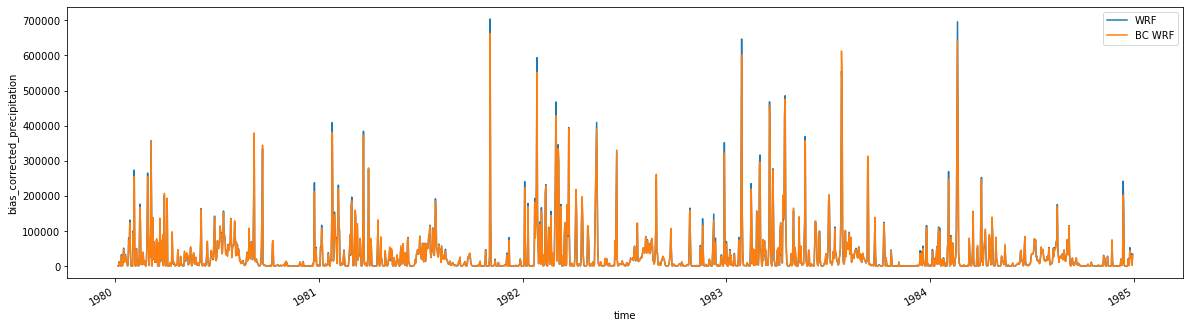

In [341]:
y=5
fig, ax = plt.subplots(figsize=(20,5))
ds.model_precipitation.sum(dim='projection_x_coordinate').sum(dim='projection_y_coordinate').isel(time=slice(y,365*y)).plot(ax=ax, label='WRF')
ds.bias_corrected_precipitation.sum(dim='projection_x_coordinate').sum(dim='projection_y_coordinate').isel(time=slice(y,365*y)).plot(ax=ax, label='BC WRF')
ax.legend()
plt.show()